# Used Cars Pricing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

    1. Data Understanding and Preparation:
        A. Read the ‘used_cars_data.csv’ dataset, check the dimensions and print the first 10 rows. 

In [2]:
df = pd.read_csv('used_cars_data.csv') 
print(f'Shape : {df.shape}, and size of Normal File : {df.size}')

Shape : (7253, 14), and size of Normal File : 101542


In [3]:
df.head(10)

S.No.                                 Name    Location  Year  \
0      0               Maruti Wagon R LXI CNG      Mumbai  2010   
1      1     Hyundai Creta 1.6 CRDi SX Option        Pune  2015   
2      2                         Honda Jazz V     Chennai  2011   
3      3                    Maruti Ertiga VDI     Chennai  2012   
4      4      Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013   
5      5      Hyundai EON LPG Era Plus Option   Hyderabad  2012   
6      6               Nissan Micra Diesel XV      Jaipur  2013   
7      7    Toyota Innova Crysta 2.8 GX AT 8S      Mumbai  2016   
8      8  Volkswagen Vento Diesel Comfortline        Pune  2013   
9      9       Tata Indica Vista Quadrajet LS     Chennai  2012   

   Kilometers_Driven Fuel_Type Transmission Owner_Type     Mileage   Engine  \
0              72000       CNG       Manual      First  26.6 km/kg   998 CC   
1              41000    Diesel       Manual      First  19.67 kmpl  1582 CC   
2              46000    Petrol       Manual      First   18.2 kmpl  1199 CC   
3              87000    Diesel       Manual      First  20.77 kmpl  1248 CC   
4              40670    Diesel    Automatic     Second   15.2 kmpl  1968 CC   
5              75000       LPG       Manual      First  21.1 km/kg   814 CC   
6              86999    Diesel       Manual      First  23.08 kmpl  1461 CC   
7              36000    Diesel    Automatic      First  11.36 kmpl  2755 CC   
8              64430    Diesel       Manual      First  20.54 kmpl  1598 CC   
9              65932    Diesel       Manual     Second   22.3 kmpl  1248 CC   

       Power  Seats  New_Price  Price  
0  58.16 bhp    5.0       5.51   1.75  
1  126.2 bhp    5.0      16.06  12.50  
2   88.7 bhp    5.0       8.61   4.50  
3  88.76 bhp    7.0      11.27   6.00  
4  140.8 bhp    5.0      53.14  17.74  
5   55.2 bhp    5.0      10.25   2.35  
6   63.1 bhp    5.0       9.47   3.50  
7  171.5 bhp    8.0      21.00  17.50  
8  103.6 bhp    5.0      13.23   5.20  
9     74 bhp    5.0       7.63   1.95

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7078 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          7253 non-null   float64
 13  Price              6019 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 793.4+ KB


    B. Check data types and duplicate values in the data-frame. Treat the duplicates if any, with an explanation to your approach.    

In [5]:
# Check for duplicate rows in the entire DataFrame
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print("Duplicate Rows:")
    print(duplicates)
else:
    print("No Duplicate Rows Found.")

No Duplicate Rows Found.


    C. Observe if there’s any relationship between the units given in the mileage column and the Fuel_Type .Split mileage column into numeric values and units.   

In [6]:
df['Mileage_numeric'] = df['Mileage'].str.extract('(\d+\.\d+|\d+)').astype(float)
df['Mileage_unit'] = df['Mileage'].str.extract('([a-zA-Z]+)').astype(str)
print(df[['Mileage_unit', 'Mileage_numeric']].head(3))

  Mileage_unit  Mileage_numeric
0           km            26.60
1         kmpl            19.67
2         kmpl            18.20


In [7]:
# Analyze the relationship between 'mileage_unit' and 'Fuel_Type'
relationship_analysis = df.groupby(['Mileage_unit', 'Fuel_Type']).size().reset_index(name='count')
print("\nRelationship between Mileage Unit and Fuel Type:")
print(relationship_analysis)


Relationship between Mileage Unit and Fuel Type:
  Mileage_unit Fuel_Type  count
0           km       CNG     62
1           km       LPG     12
2         kmpl    Diesel   3852
3         kmpl    Petrol   3325
4          nan  Electric      2


    D. Extract numeric values from ‘Engine’, ‘Power’ and ‘New_Price’. Check for variation in their units and drop the units if necessary   

In [8]:
# New_Price does not have unit hence we will move forward with Engine and Power
df['Engine_numeric'] = df['Engine'].str.extract('(\d+\.\d+|\d+)').astype(float)
df['Power_numeric'] = df['Power'].str.extract('(\d+\.\d+|\d+)').astype(float)

# Display the DataFrame with the new numeric columns
print("DataFrame with Numeric Values:")
df[['Engine_numeric', 'Power_numeric']].head(3)

DataFrame with Numeric Values:


Engine_numeric  Power_numeric
0           998.0          58.16
1          1582.0         126.20
2          1199.0          88.70

In [9]:
# Check for variation in units and drop them if necessary
df['Engine_unit'] = df['Engine'].str.extract('([a-zA-Z]+)').astype(str)
df['Power_unit'] = df['Power'].str.extract('([a-zA-Z]+)').astype(str)

# Display the DataFrame with the new numeric columns
print("DataFrame with Numeric Values:")
df[['Engine_unit', 'Power_unit']].head(3)

DataFrame with Numeric Values:


Engine_unit Power_unit
0          CC        bhp
1          CC        bhp
2          CC        bhp

In [10]:
print(f"Unique Value in Engine_Unit : {df['Engine_unit'].unique()}, and Power_unit : {df['Power_unit'].unique()}")

Unique Value in Engine_Unit : ['CC' 'nan'], and Power_unit : ['bhp' 'nan']


In [11]:
# Display variation in units
print("\nVariation in Units:")
print("Engine Units:", df['Engine_unit'].unique())
print("Power Units:", df['Power_unit'].unique())

df.drop(['Engine_unit', 'Power_unit'], axis=1, inplace=True)

# Display the DataFrame after dropping unit columns
print("\nDataFrame after Dropping Unit Columns:")
df.head(3)


Variation in Units:
Engine Units: ['CC' 'nan']
Power Units: ['bhp' 'nan']

DataFrame after Dropping Unit Columns:


S.No.                              Name Location  Year  Kilometers_Driven  \
0      0            Maruti Wagon R LXI CNG   Mumbai  2010              72000   
1      1  Hyundai Creta 1.6 CRDi SX Option     Pune  2015              41000   
2      2                      Honda Jazz V  Chennai  2011              46000   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   

   New_Price  Price  Mileage_numeric Mileage_unit  Engine_numeric  \
0       5.51   1.75            26.60           km           998.0   
1      16.06  12.50            19.67         kmpl          1582.0   
2       8.61   4.50            18.20         kmpl          1199.0   

   Power_numeric  
0          58.16  
1         126.20  
2          88.70

In [12]:
# Droping Mileage. Engine and Power Col, S.No.
df.drop(['Mileage','Engine', 'Power','S.No.'], axis=1, inplace=True)

    E. Extract the Car Brand Name and Model Name from the ‘Name’ column.

In [13]:
df[['Brand', 'Model']] = df['Name'].str.split(n=1, expand=True)
df[['Name', 'Brand', 'Model']].head(3)

Name    Brand                     Model
0            Maruti Wagon R LXI CNG   Maruti           Wagon R LXI CNG
1  Hyundai Creta 1.6 CRDi SX Option  Hyundai  Creta 1.6 CRDi SX Option
2                      Honda Jazz V    Honda                    Jazz V

     F. Create new variables by log transforming ‘Price’ and ‘Kilometers_Driven’ columns as ‘price_log’ and ‘kilometers_driven_log’.

In [14]:
df['price_log'] = np.log1p(df['Price'])
df['kilometers_driven_log'] = np.log1p(df['Kilometers_Driven'])
df[['Price', 'price_log', 'Kilometers_Driven', 'kilometers_driven_log']].head(3)

Price  price_log  Kilometers_Driven  kilometers_driven_log
0   1.75   1.011601              72000              11.184435
1  12.50   2.602690              41000              10.621352
2   4.50   1.704748              46000              10.736418

In [15]:
average_prices = df.groupby('Brand')['Price'].mean().reset_index()

# Display the average prices by brand
print("Average Prices of Used Cars by Brand:")
print(average_prices)

Average Prices of Used Cars by Brand:
            Brand       Price
0      Ambassador    1.350000
1            Audi   25.537712
2             BMW   25.243146
3         Bentley   59.000000
4       Chevrolet    3.044463
5          Datsun    3.049231
6            Fiat    3.269286
7           Force    9.333333
8            Ford    6.889400
9       Hindustan         NaN
10          Honda    5.411743
11        Hyundai    5.343433
12          ISUZU   12.045000
13          Isuzu   20.000000
14         Jaguar   37.632250
15           Jeep   18.718667
16    Lamborghini  120.000000
17           Land   39.259500
18       Mahindra    8.045919
19         Maruti    4.517267
20  Mercedes-Benz   26.809874
21           Mini   26.896923
22     Mitsubishi   11.058889
23         Nissan    4.738352
24      OpelCorsa         NaN
25        Porsche   48.348333
26        Renault    5.799034
27          Skoda    7.559075
28          Smart    3.000000
29           Tata    3.562849
30         Toyota   11.580024
31

In [16]:
# Droping Price and Kilometers_Driven

df.drop(['Price', 'Kilometers_Driven'], axis=1, inplace=True)

    G. Drop the redundant columns and print a 5-point summary of the data-frame and share your observation. 
    H. Check the missing values and extreme values in the dataset and impute them. [1 Mark](Do not impute missing values for price as it is our target column).

In [17]:
# Before 5-point we need to remove the NAN values.

# df.isnull().sum()

In [18]:
# Since this are not continuous the missing values cannot be filled
df = df.dropna()
df.isnull().sum()

Name                     0
Location                 0
Year                     0
Fuel_Type                0
Transmission             0
Owner_Type               0
Seats                    0
New_Price                0
Mileage_numeric          0
Mileage_unit             0
Engine_numeric           0
Power_numeric            0
Brand                    0
Model                    0
price_log                0
kilometers_driven_log    0
dtype: int64

In [19]:
df.describe().transpose()

count         mean         std          min  \
Year                   5872.0  2013.477691    3.164568  1998.000000   
Seats                  5872.0     5.283719    0.805081     2.000000   
New_Price              5872.0    21.635792   24.278063     3.910000   
Mileage_numeric        5872.0    18.277839    4.365657     0.000000   
Engine_numeric         5872.0  1625.745572  601.641783   624.000000   
Power_numeric          5872.0   113.276894   53.881892    34.200000   
price_log              5872.0     2.034267    0.742900     0.364643   
kilometers_driven_log  5872.0    10.749888    0.717956     5.147494   

                               25%          50%          75%          max  
Year                   2012.000000  2014.000000  2016.000000  2019.000000  
Seats                     5.000000     5.000000     5.000000    10.000000  
New_Price                 7.960000    11.300000    23.152500   375.000000  
Mileage_numeric          15.260000    18.200000    21.100000    33.540000  
Engine_numeric         1198.000000  1495.500000  1991.000000  5998.000000  
Power_numeric            75.000000    97.700000   138.100000   560.000000  
price_log                 1.507958     1.909543     2.397895     5.081404  
kilometers_driven_log    10.417015    10.870661    11.190013    15.687313

    I. Check the distribution of non-numeric features (display the first 10 values if the number of categories/ classes are more than 10).

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5872 entries, 0 to 6018
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   5872 non-null   object 
 1   Location               5872 non-null   object 
 2   Year                   5872 non-null   int64  
 3   Fuel_Type              5872 non-null   object 
 4   Transmission           5872 non-null   object 
 5   Owner_Type             5872 non-null   object 
 6   Seats                  5872 non-null   float64
 7   New_Price              5872 non-null   float64
 8   Mileage_numeric        5872 non-null   float64
 9   Mileage_unit           5872 non-null   object 
 10  Engine_numeric         5872 non-null   float64
 11  Power_numeric          5872 non-null   float64
 12  Brand                  5872 non-null   object 
 13  Model                  5872 non-null   object 
 14  price_log              5872 non-null   float64
 15  kilo

In [21]:
non_numeric_columns = df.select_dtypes(include=['object']).columns
numeric_columns = df.select_dtypes(include='number').columns

    J. Share the average of used car prices by brand.

    2. Data Exploration and Analysis: [10 Marks] 
        A. Perform Univariate Analysis on numerical and Categorical data. Share your insights.
        B. Perform detailed Bivariate and Multivariate Analysis on the data and share your insights

Number of non numeric col : 8


C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\4269493573.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


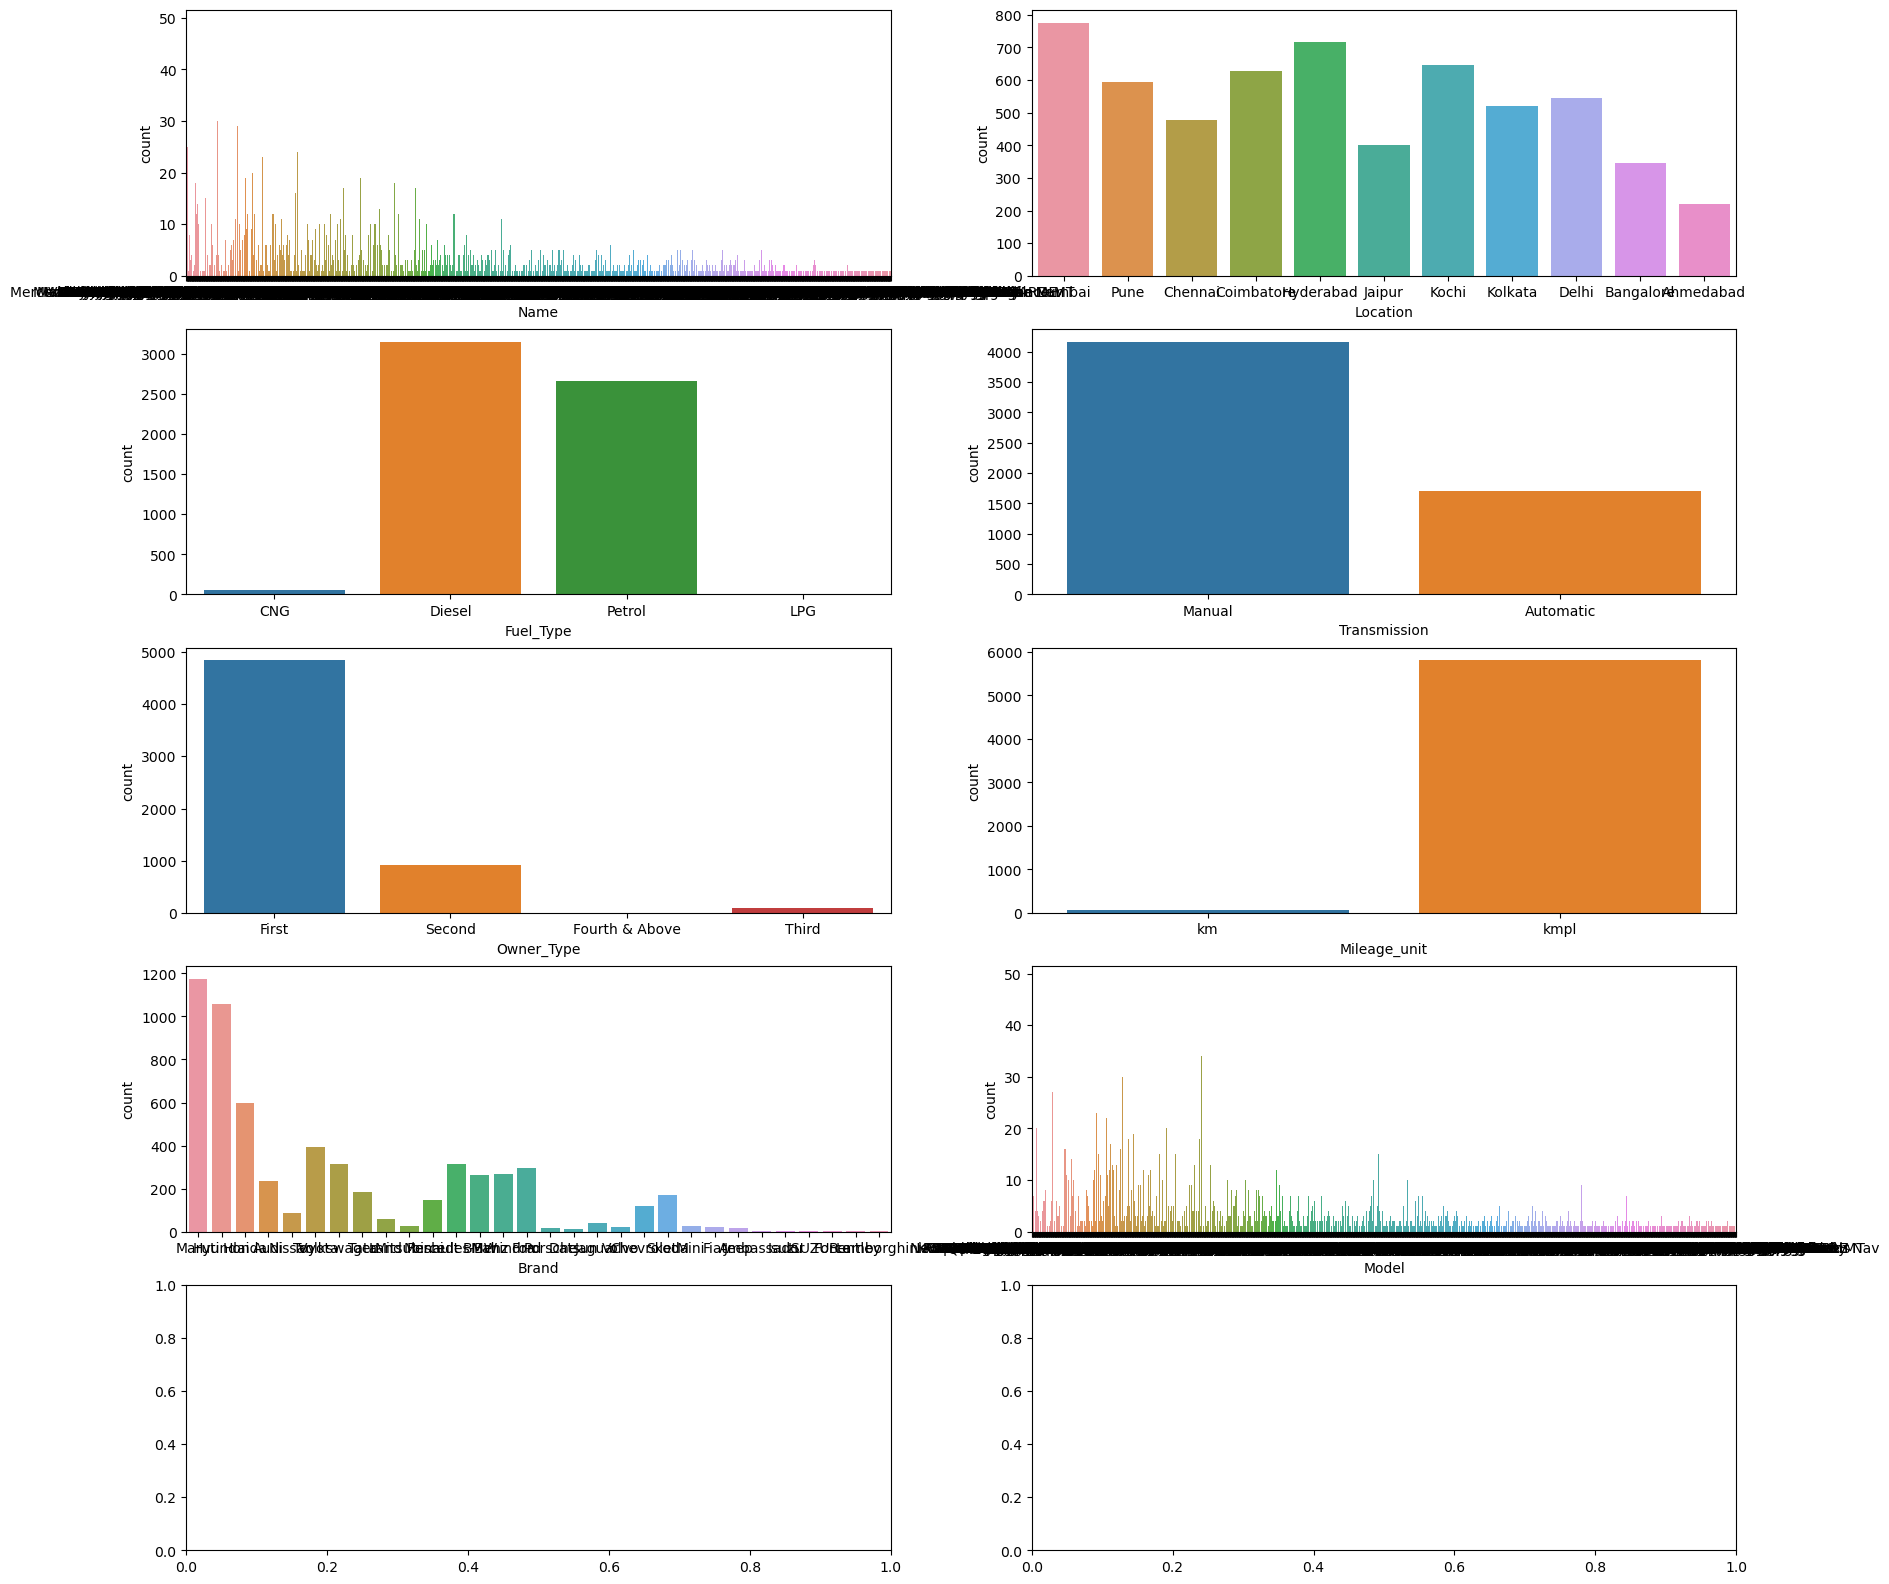

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(20,20))
len_non_numeric_columns = len(non_numeric_columns)
print(f"Number of non numeric col : {len_non_numeric_columns}")
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if(index < len_non_numeric_columns):
            ax[j][i] = sns.countplot(data = df, x = df[non_numeric_columns[index]],ax = ax[j][i])          
#             ax.set_ylabel(rotation=90, fontsize=14, labelpad=20)
#             ax.yaxis.set_label_coords(-0.1, 0.5)
            index = index + 1 
#    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90);
fig.show()

Number of non numeric col : 8


C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\4220027002.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


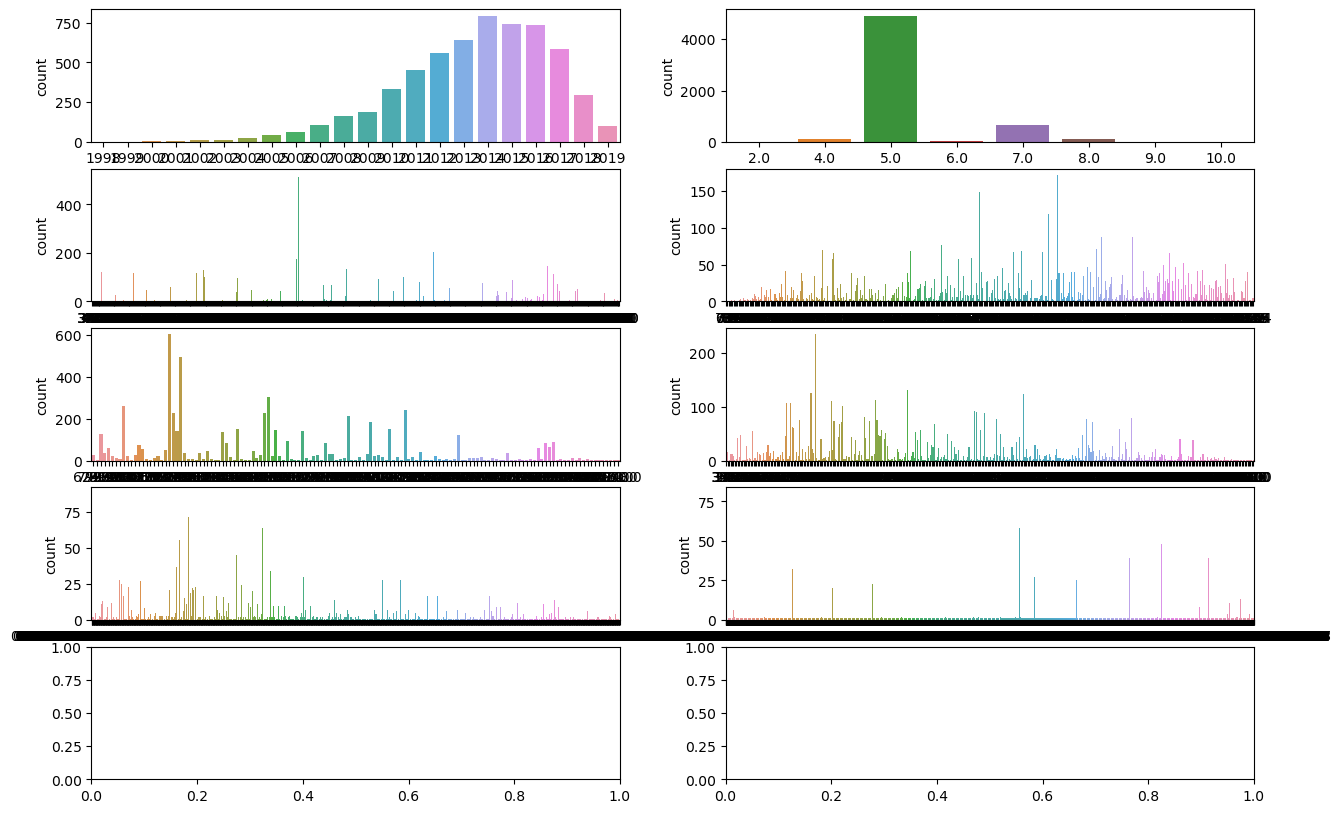

In [23]:
fig, ax = plt.subplots(5,2, figsize=(15,10))
len_numeric_columns = len(numeric_columns)
print(f"Number of non numeric col : {len_numeric_columns}")

index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if(index < len_numeric_columns):
            ax[j][i] = sns.countplot(data=df, x = df[numeric_columns[index]],ax = ax[j][i])            
            index = index + 1 
fig.show()

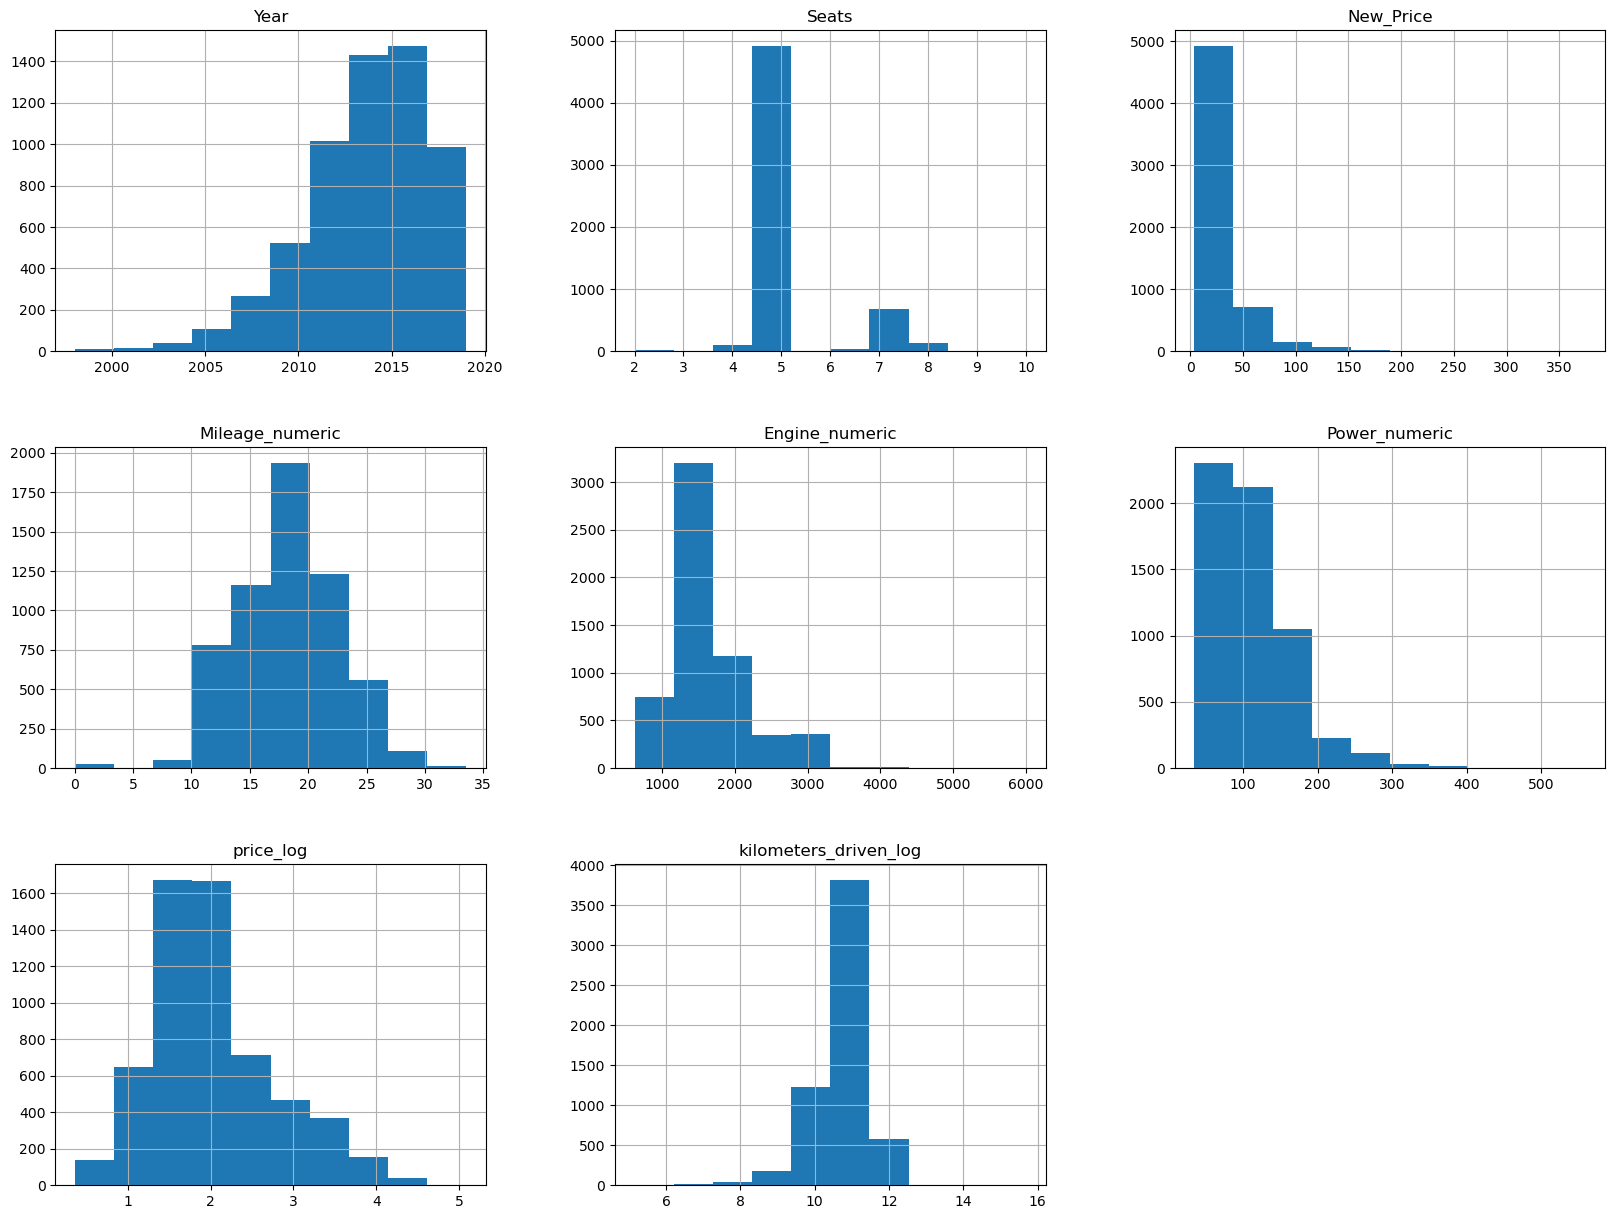

In [24]:
df.hist(figsize = (20,15))
plt.show()

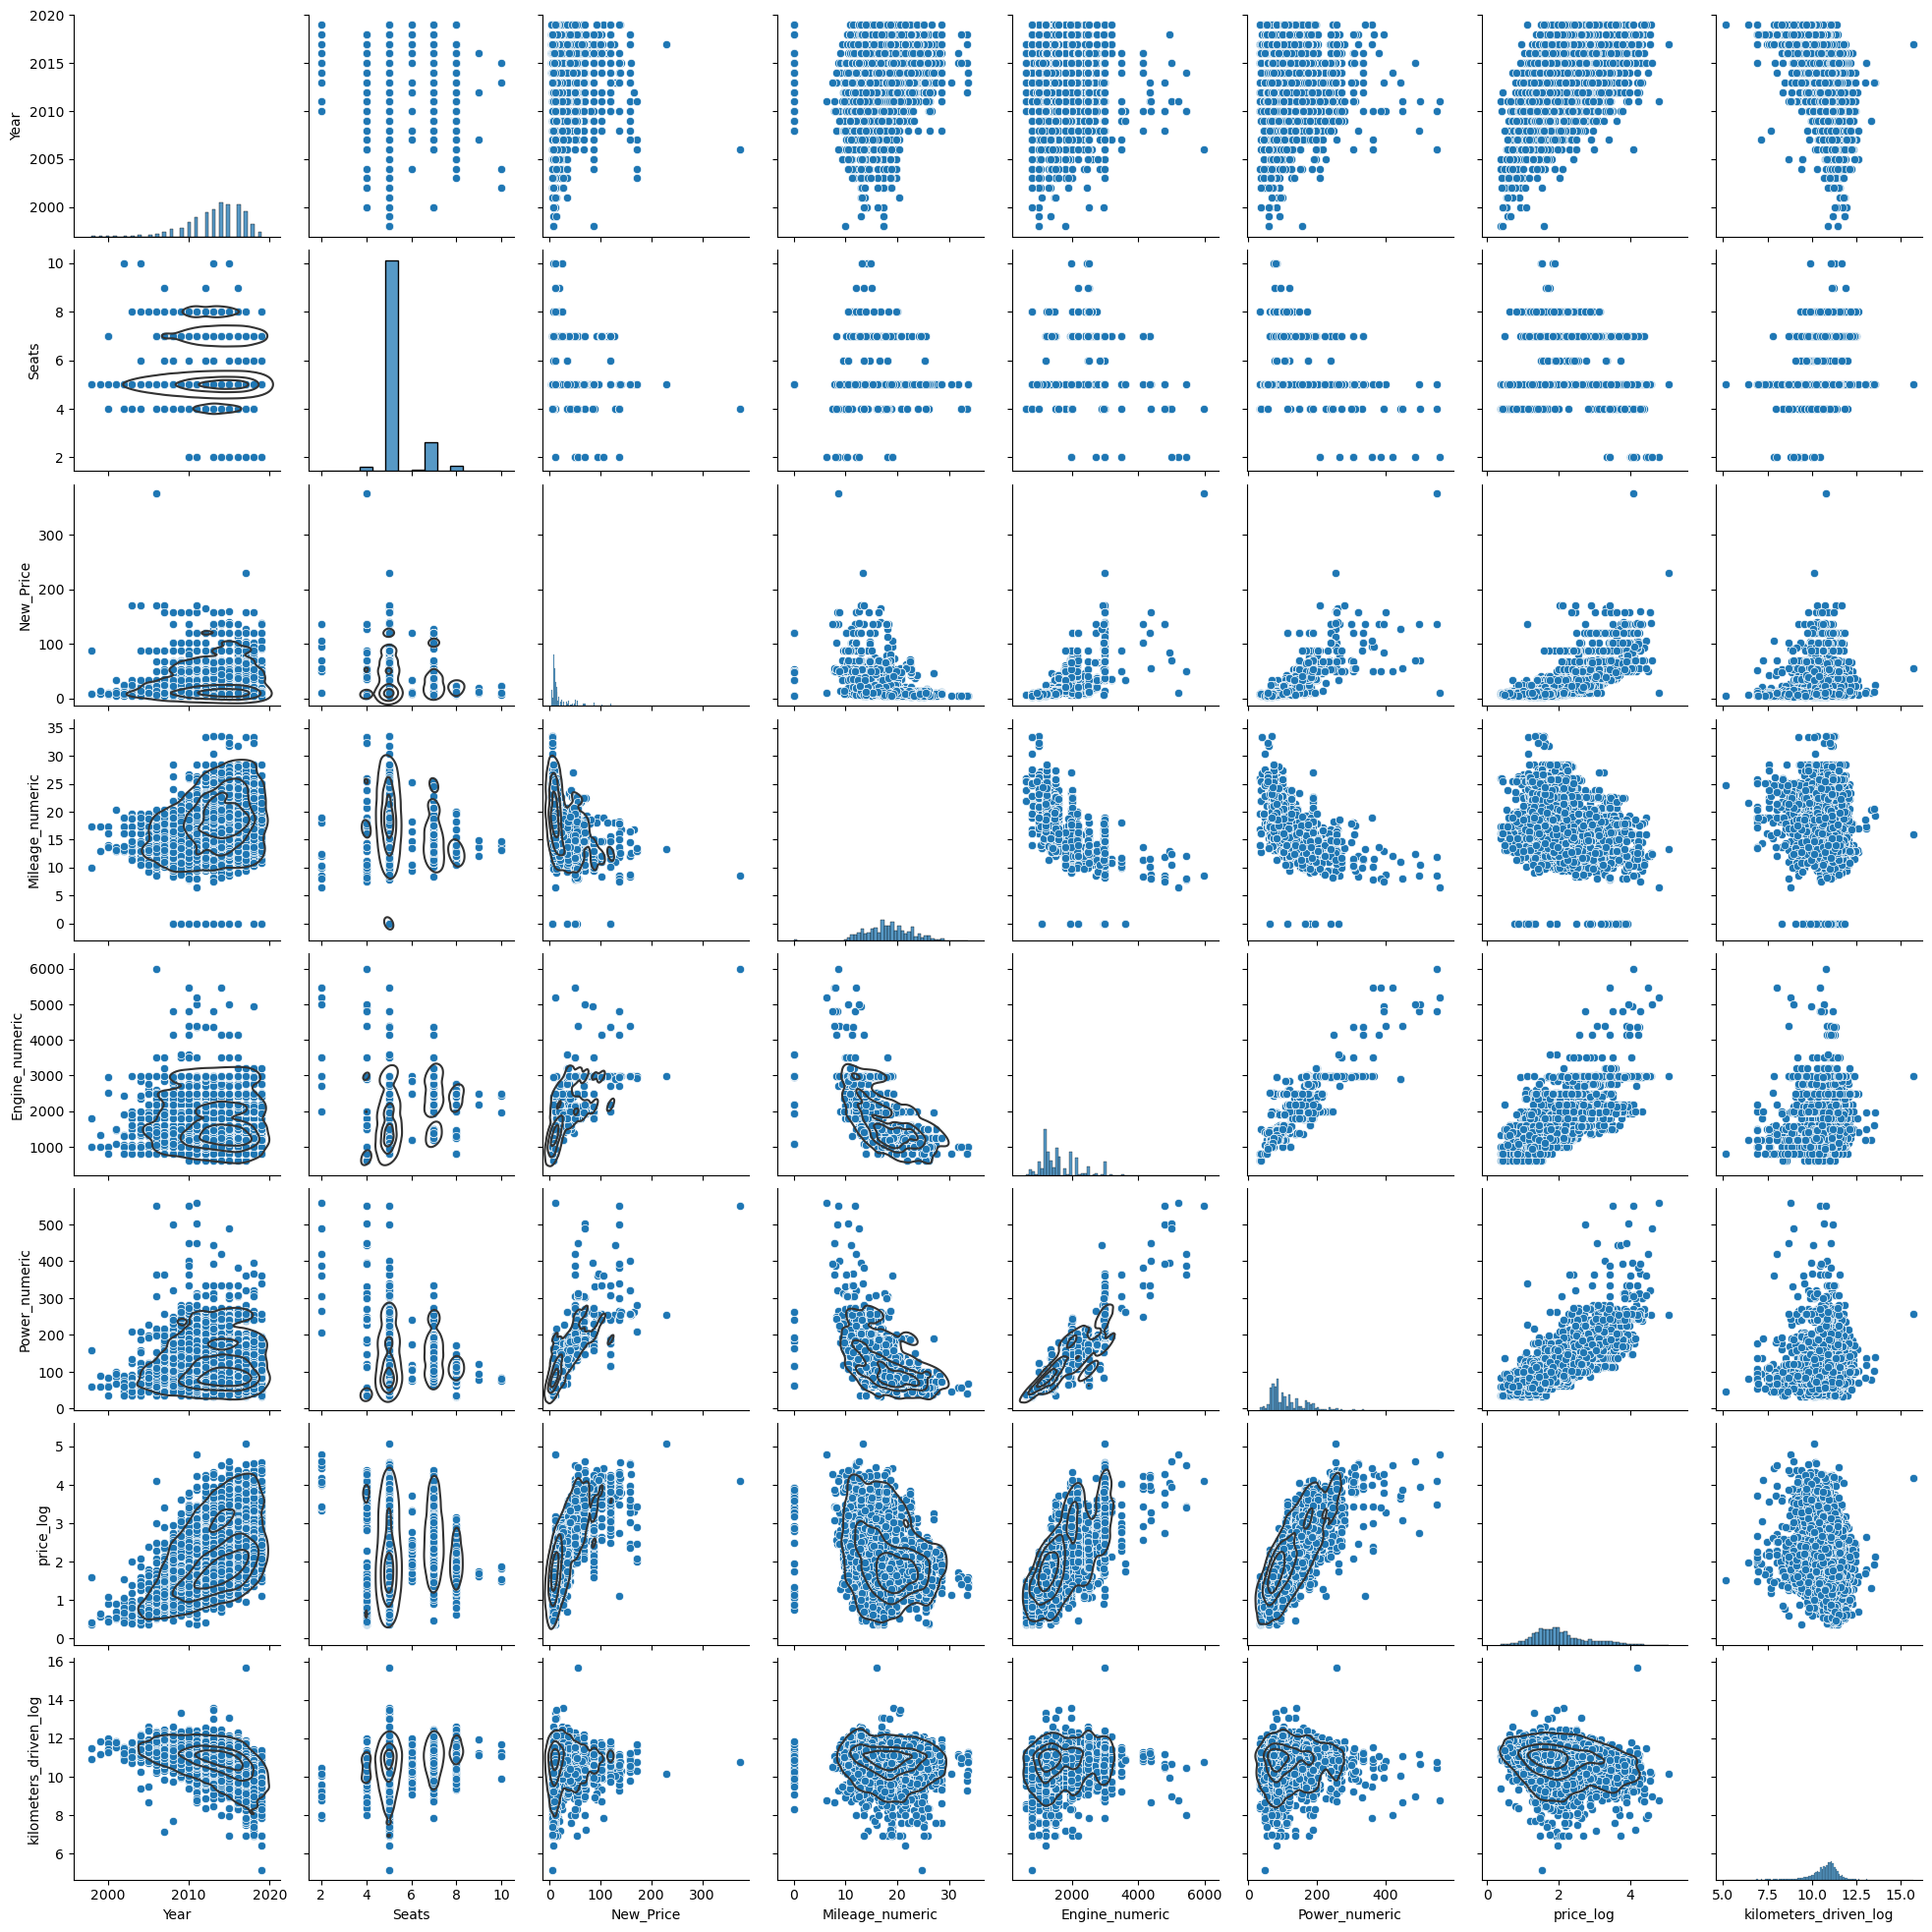

In [25]:
g = sns.pairplot(df, diag_kind="hist")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [26]:
selected_columns = ['kilometers_driven_log', 'New_Price','price_log','Mileage_numeric','Engine_numeric','Power_numeric']
threshold = 3
# Iterate over selected columns and remove outliers using Z-score
for column in selected_columns:
    if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
        z_scores = np.abs(stats.zscore(df[column]))
        outliers = (z_scores > threshold)
        df = df[~outliers]

df.describe()

Year        Seats    New_Price  Mileage_numeric  Engine_numeric  \
count  5500.000000  5500.000000  5500.000000      5500.000000     5500.000000   
mean   2013.414364     5.292545    18.361899        18.536016     1565.341273   
std       3.147599     0.788430    16.960475         4.034867      509.214132   
min    1998.000000     2.000000     3.910000         8.700000      624.000000   
25%    2012.000000     5.000000     7.880000        15.730000     1197.000000   
50%    2014.000000     5.000000    11.300000        18.500000     1461.000000   
75%    2016.000000     5.000000    18.865000        21.140000     1968.000000   
max    2019.000000    10.000000    86.970000        30.460000     3200.000000   

       Power_numeric    price_log  kilometers_driven_log  
count    5500.000000  5500.000000            5500.000000  
mean      106.703911     1.960226              10.794717  
std        41.373335     0.664354               0.615691  
min        34.200000     0.364643               8.604654  
25%        74.000000     1.504077              10.463132  
50%        90.000000     1.871802              10.887456  
75%       126.320000     2.302585              11.198228  
max       241.400000     4.060443              12.611541

Number of non numeric col : 6


C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\3000815734.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


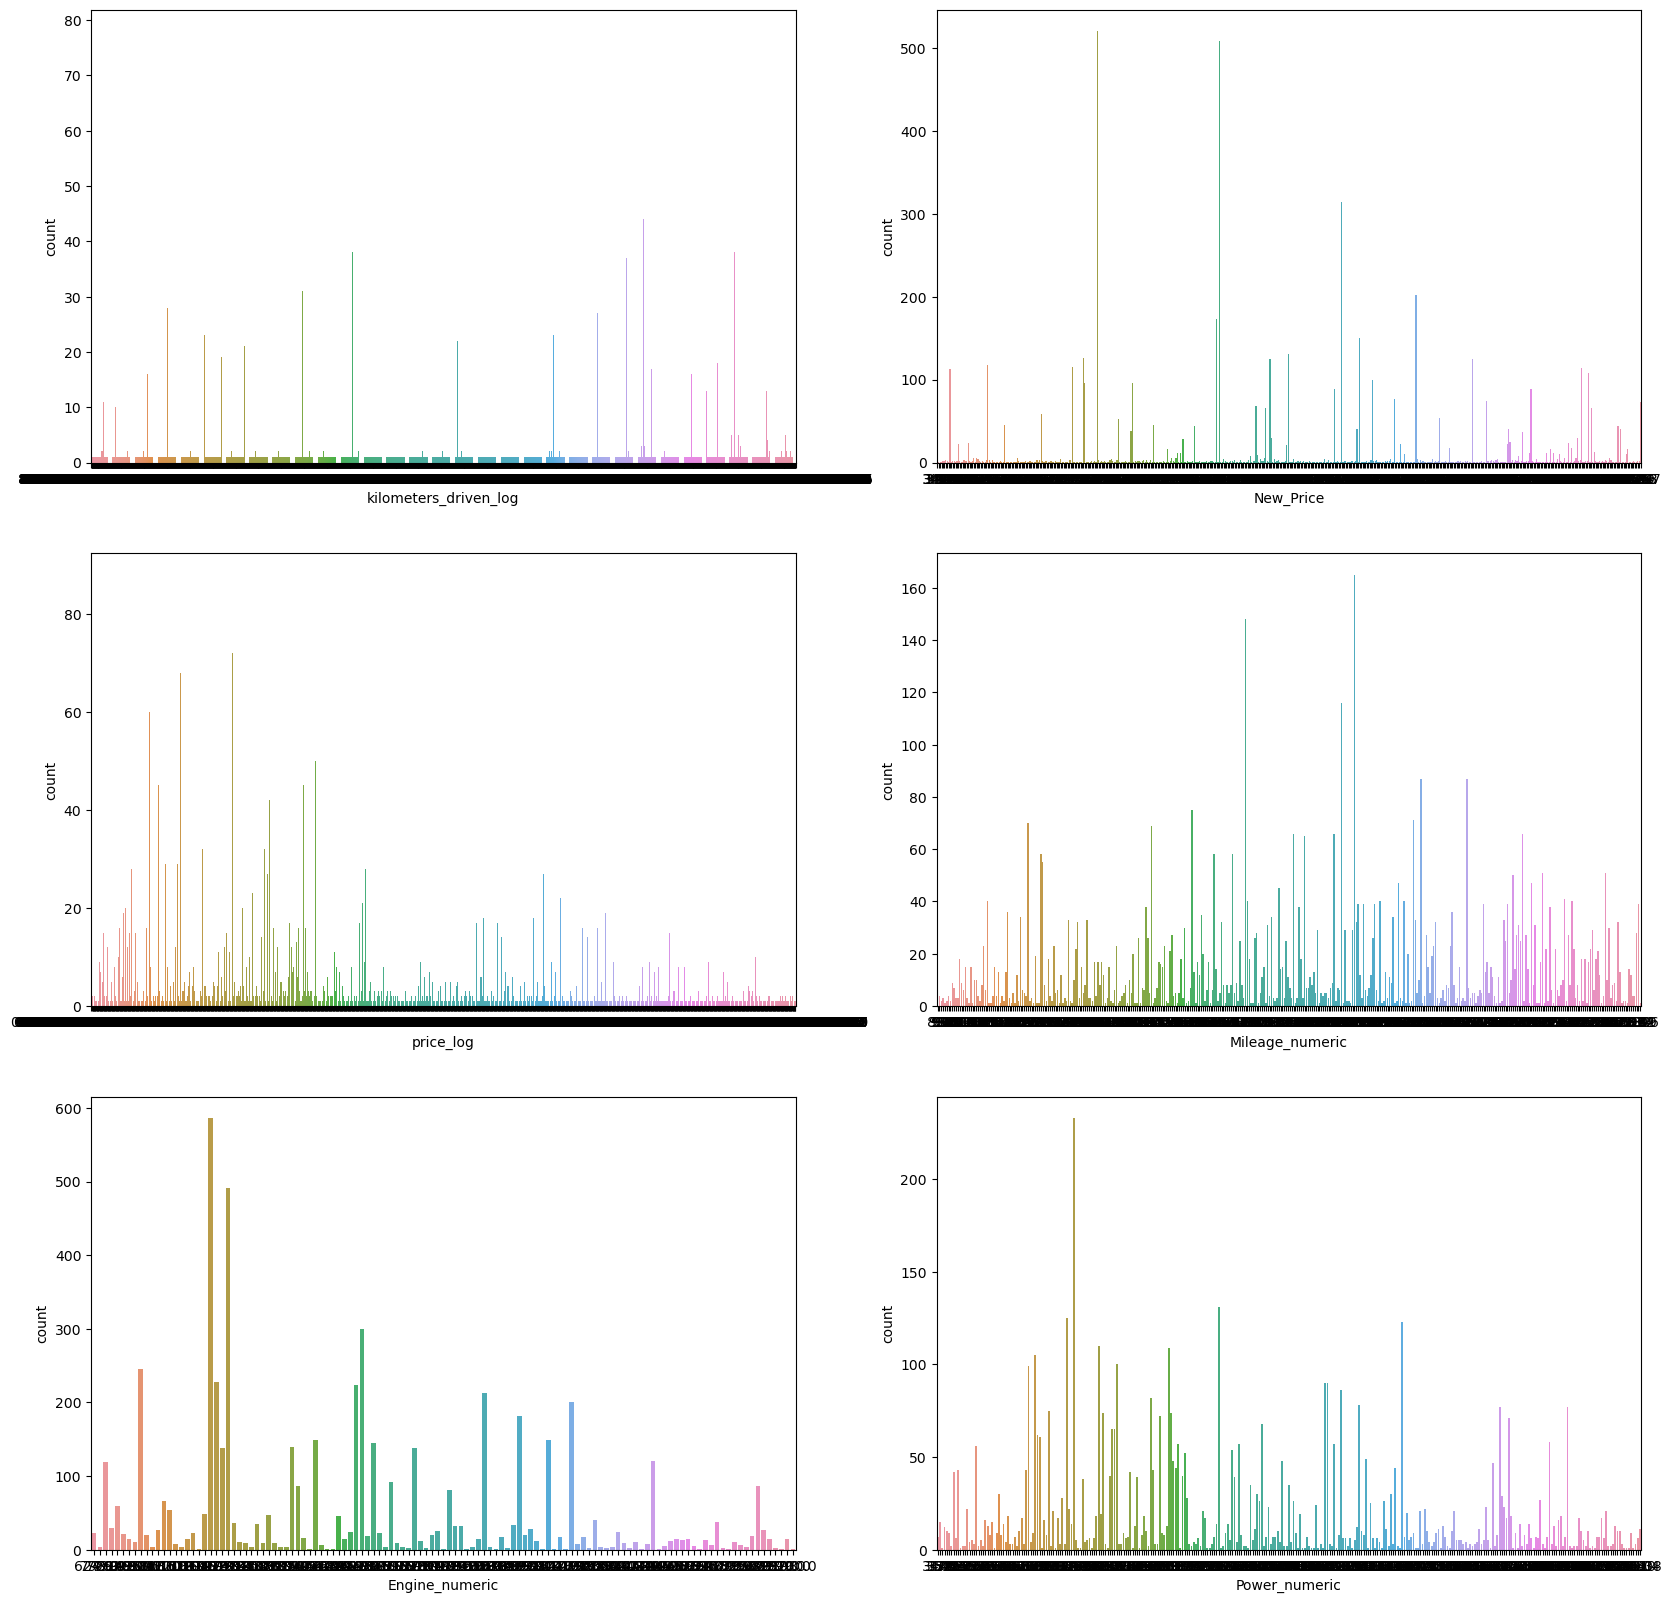

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))
len_selected_columns = len(selected_columns)
print(f"Number of non numeric col : {len_selected_columns}")

index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if(index < len_selected_columns):
            ax[j][i] = sns.countplot(data=df, x = df[selected_columns[index]],ax = ax[j][i])            
            index = index + 1 
fig.show()

Number of non numeric col : 6


C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\1526822043.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


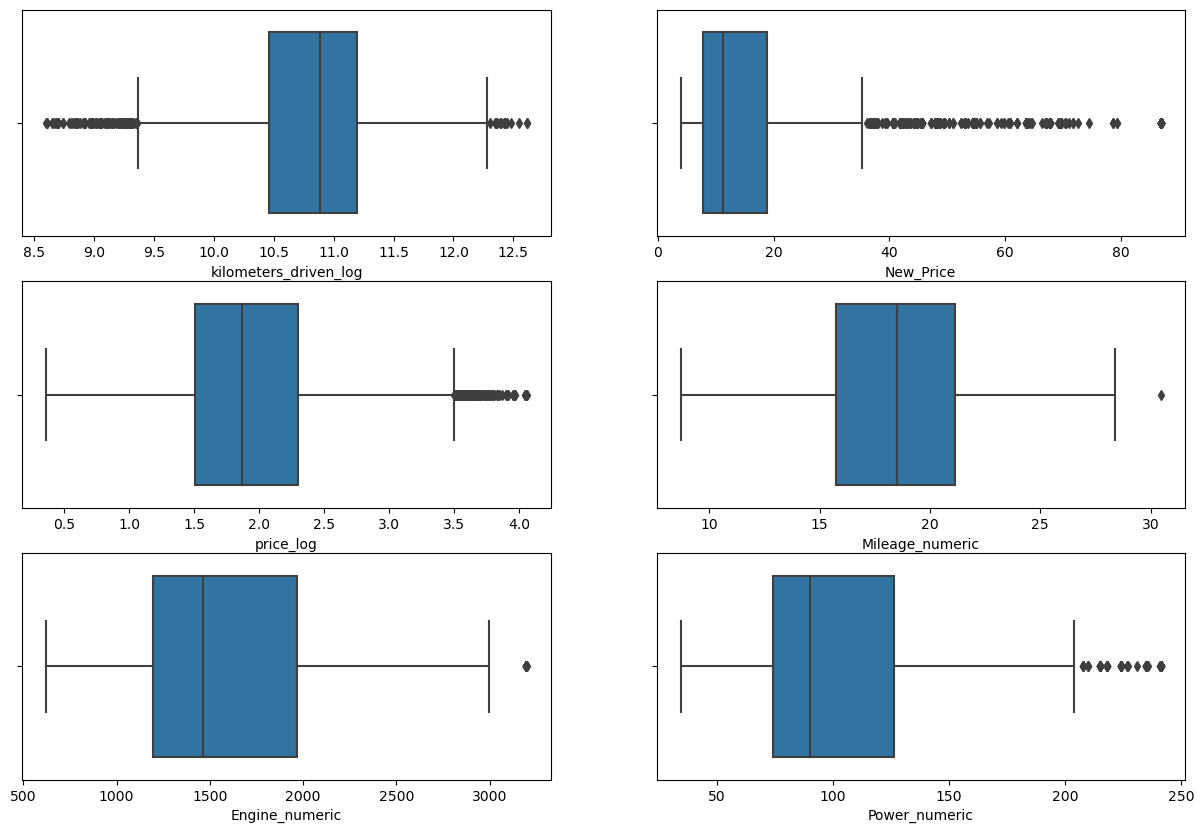

In [28]:
selected_columns = ['kilometers_driven_log', 'New_Price','price_log','Mileage_numeric','Engine_numeric','Power_numeric']

fig, ax = plt.subplots(3,2, figsize=(15,10))
len_selected_columns = len(selected_columns)
print(f"Number of non numeric col : {len_selected_columns}")

index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if(index < len_selected_columns):
            ax[j][i] = sns.boxplot(data=df, x = df[selected_columns[index]],ax = ax[j][i])            
            index = index + 1 
fig.show()

In [29]:
for column in non_numeric_columns:
    print(f"\nDistribution of {column}:")
    print(df[column].value_counts())


Distribution of Name:
Mahindra XUV500 W8 2WD                 49
Maruti Swift VDI                       45
Maruti Swift Dzire VDI                 34
Honda City 1.5 S MT                    34
Maruti Ritz VDi                        30
                                       ..
Chevrolet Sail Hatchback 1.2 LS ABS     1
Skoda Superb 2.5 TDi AT                 1
Toyota Corolla Altis D-4D G             1
Honda Brio 1.2 VX AT                    1
Mahindra Xylo D4 BSIV                   1
Name: Name, Length: 1660, dtype: int64

Distribution of Location:
Mumbai        714
Hyderabad     674
Kochi         605
Coimbatore    569
Pune          562
Delhi         512
Kolkata       490
Chennai       451
Jaipur        394
Bangalore     316
Ahmedabad     213
Name: Location, dtype: int64

Distribution of Fuel_Type:
Diesel    2915
Petrol    2533
CNG         42
LPG         10
Name: Fuel_Type, dtype: int64

Distribution of Transmission:
Manual       4090
Automatic    1410
Name: Transmission, dtype: int64

Dis

    2. Data Exploration and Analysis: 
        A. Perform Univariate Analysis on numerical and Categorical data. Share your insights. 
        B. Perform detailed Bivariate and Multivariate Analysis on the data and share your insights.

C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\259757843.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

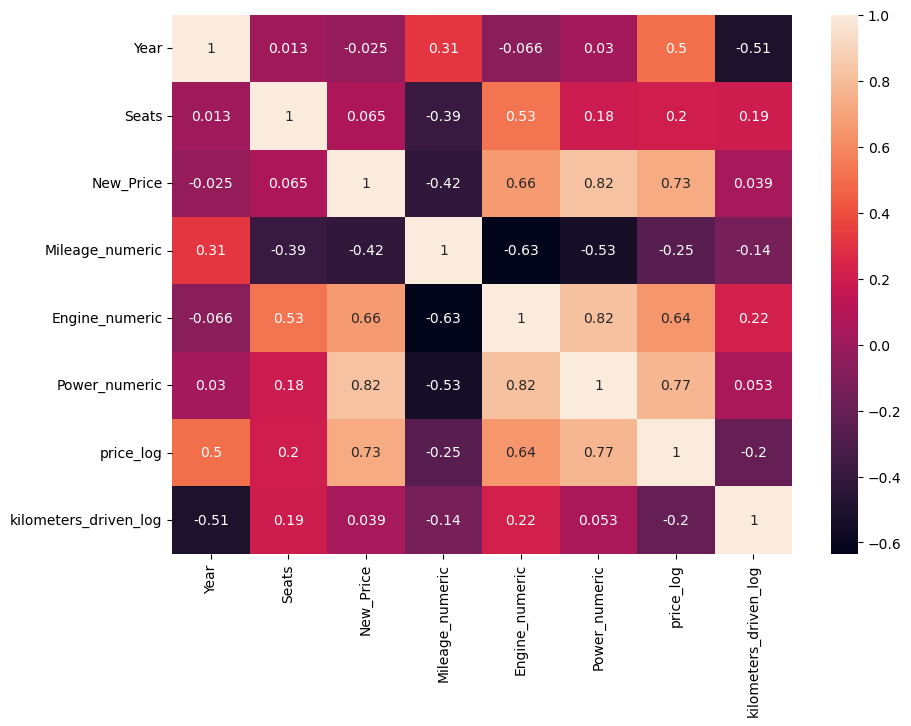

In [30]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True)

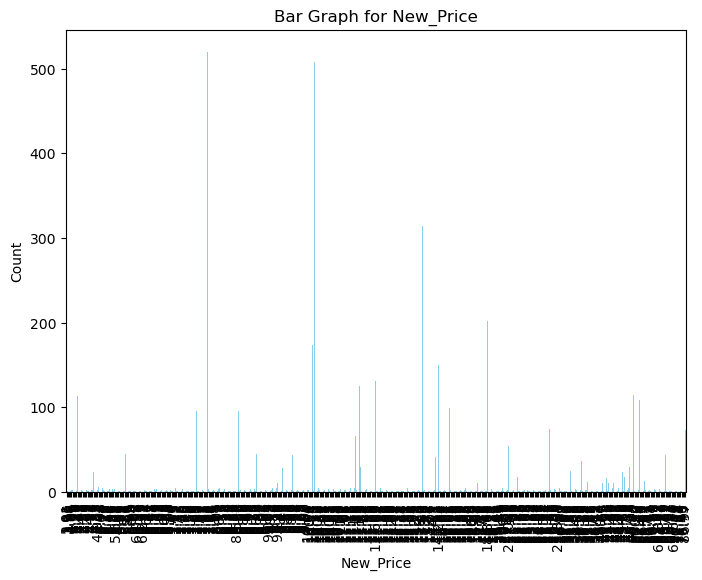

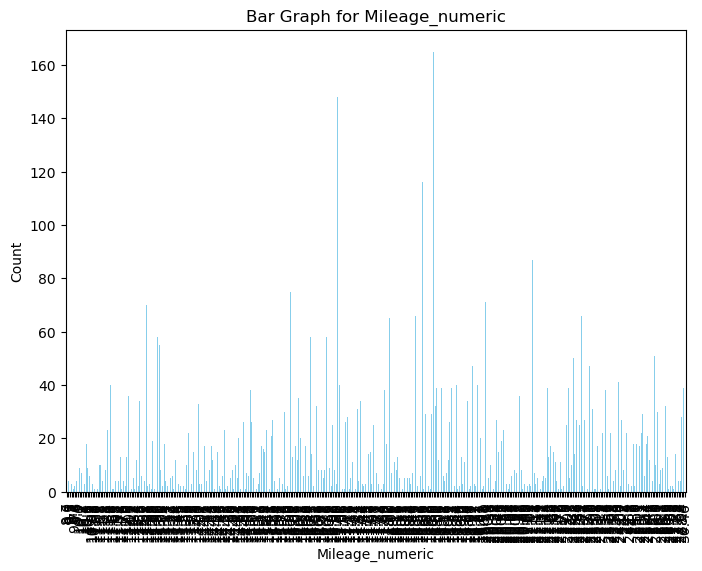

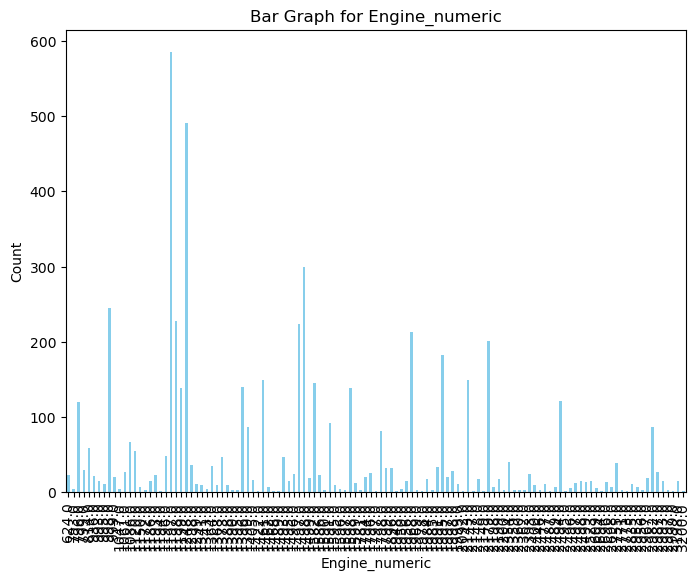

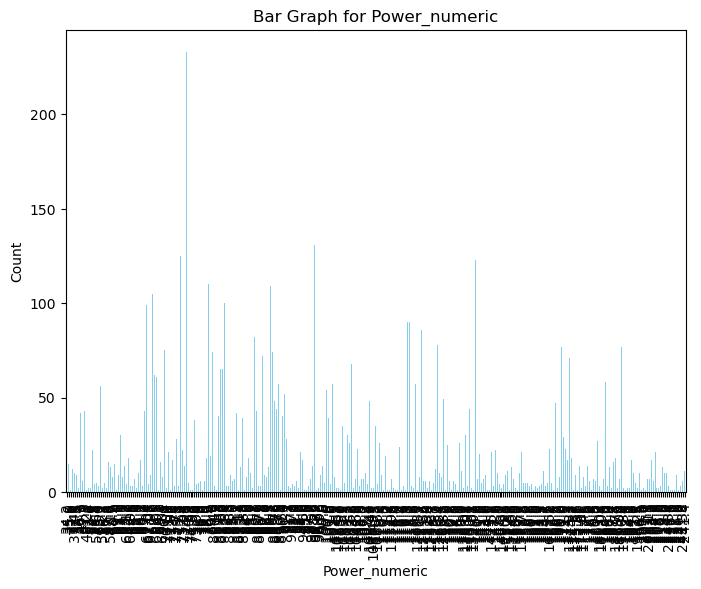

In [31]:
def plot_col(df, selected_columns):
    selected_columns = ['Kilometers_Driven', 'New_Price','Price','Mileage_numeric','Engine_numeric','Power_numeric']
    for column in selected_columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            plt.figure(figsize=(8, 6))
            df[column].value_counts().sort_index().plot(kind='bar', color='skyblue')
            plt.title(f'Bar Graph for {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.xticks(rotation = 90)
            plt.show()

# Example usage:
selected_columns_to_plot = ['Category', 'Count']
plot_col(df, selected_columns_to_plot)

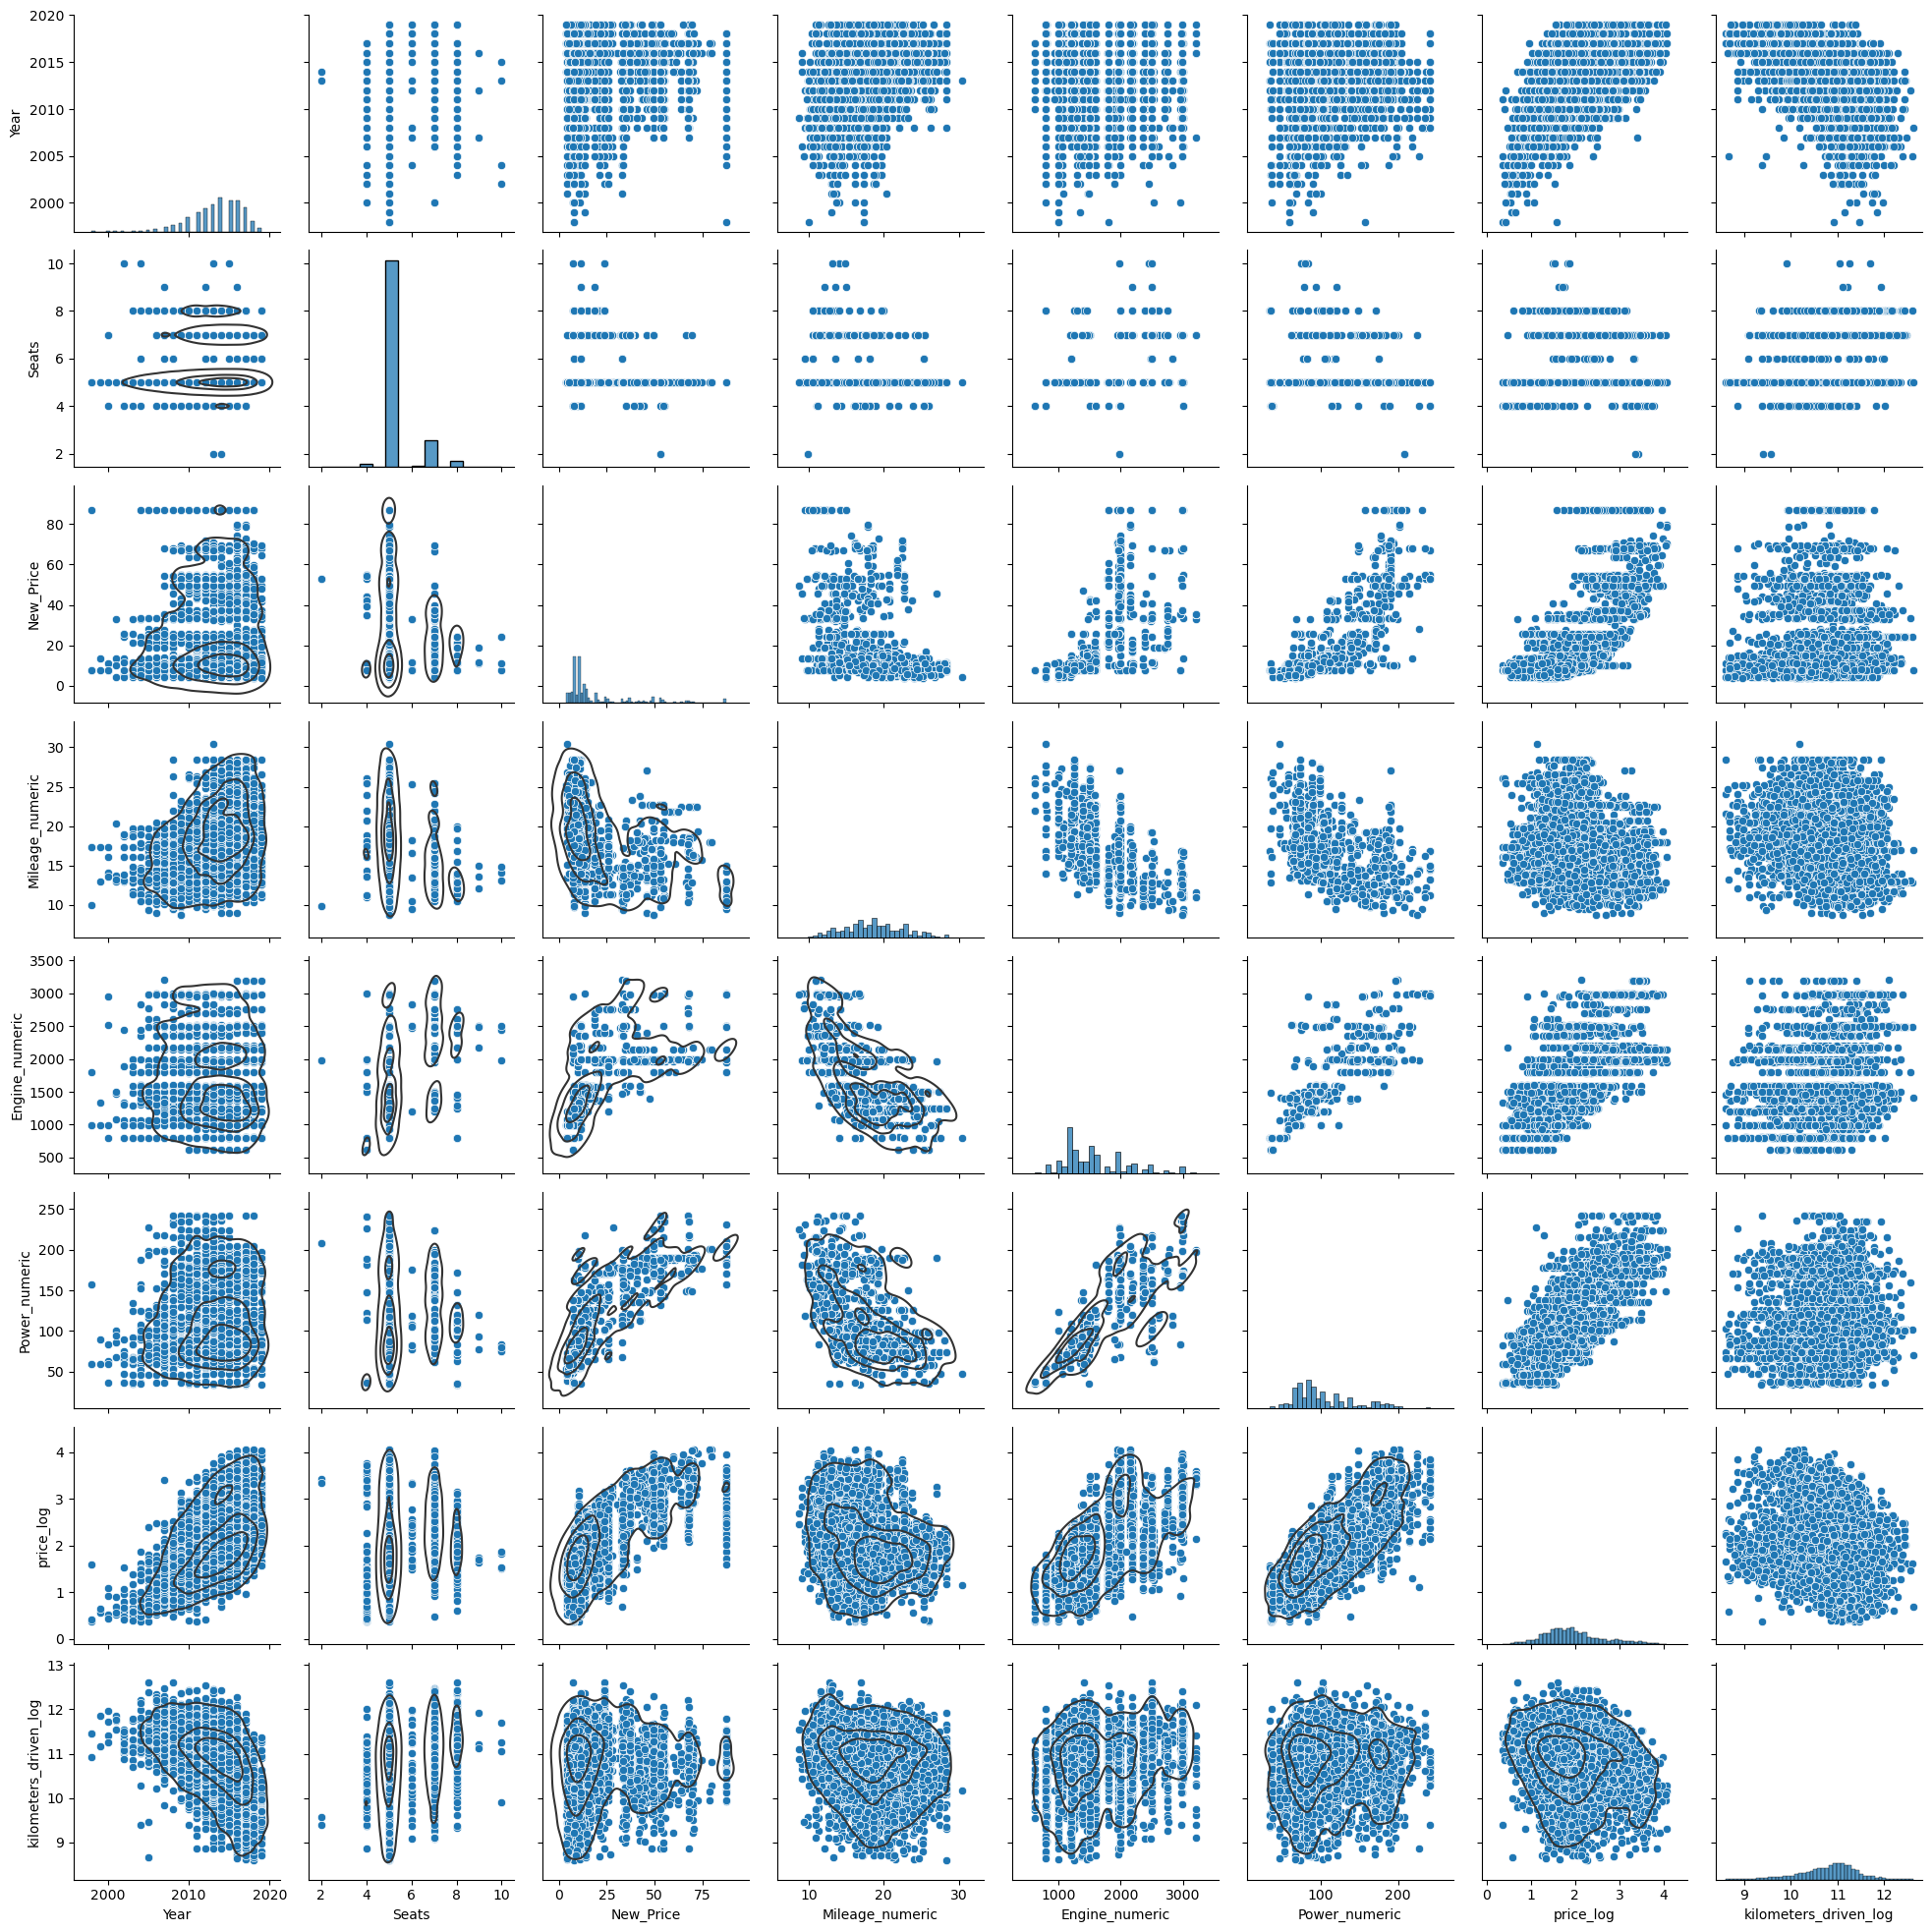

In [32]:
g = sns.pairplot(df, diag_kind="hist")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5500 entries, 0 to 6018
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   5500 non-null   object 
 1   Location               5500 non-null   object 
 2   Year                   5500 non-null   int64  
 3   Fuel_Type              5500 non-null   object 
 4   Transmission           5500 non-null   object 
 5   Owner_Type             5500 non-null   object 
 6   Seats                  5500 non-null   float64
 7   New_Price              5500 non-null   float64
 8   Mileage_numeric        5500 non-null   float64
 9   Mileage_unit           5500 non-null   object 
 10  Engine_numeric         5500 non-null   float64
 11  Power_numeric          5500 non-null   float64
 12  Brand                  5500 non-null   object 
 13  Model                  5500 non-null   object 
 14  price_log              5500 non-null   float64
 15  kilo

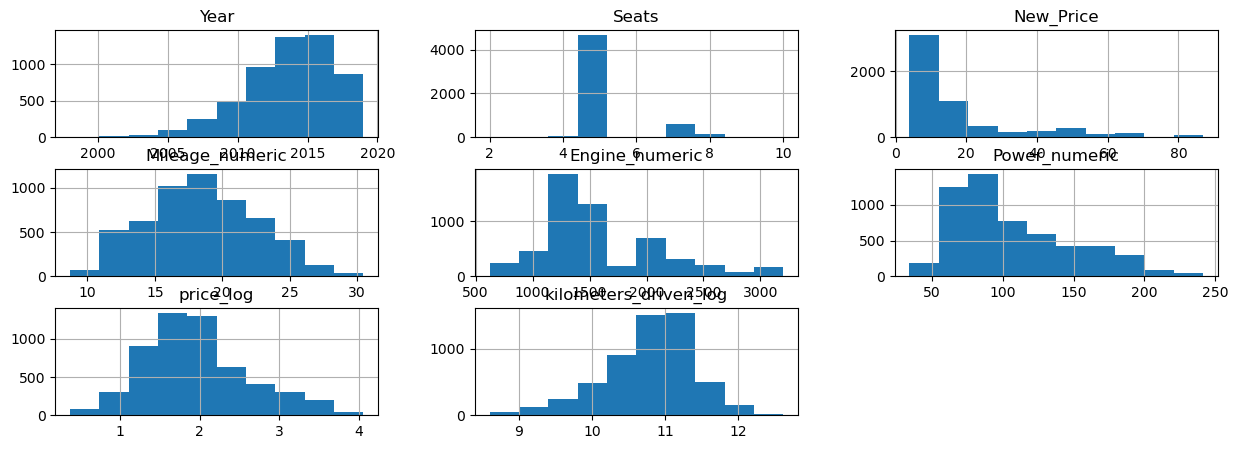

In [34]:
df.hist(figsize = (15,5),bins=10)
plt.show();

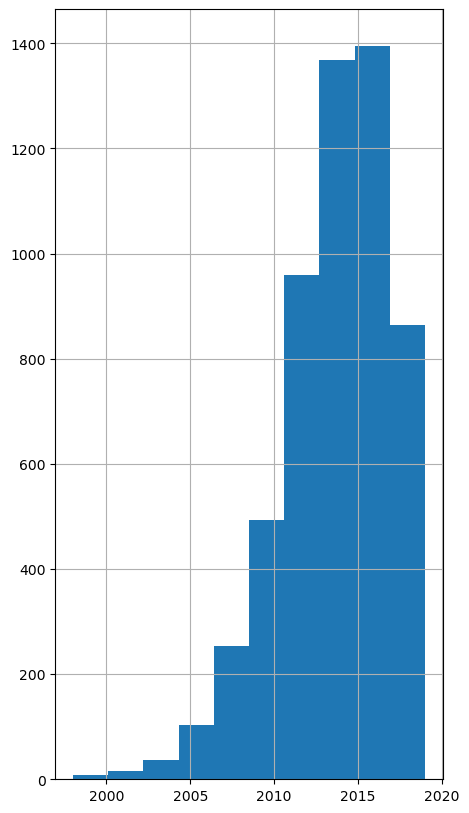

In [35]:
df['Year'].hist(figsize = (5,10),bins=10)
plt.show();

C:\Users\arvin\AppData\Local\Temp\ipykernel_6216\659285978.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


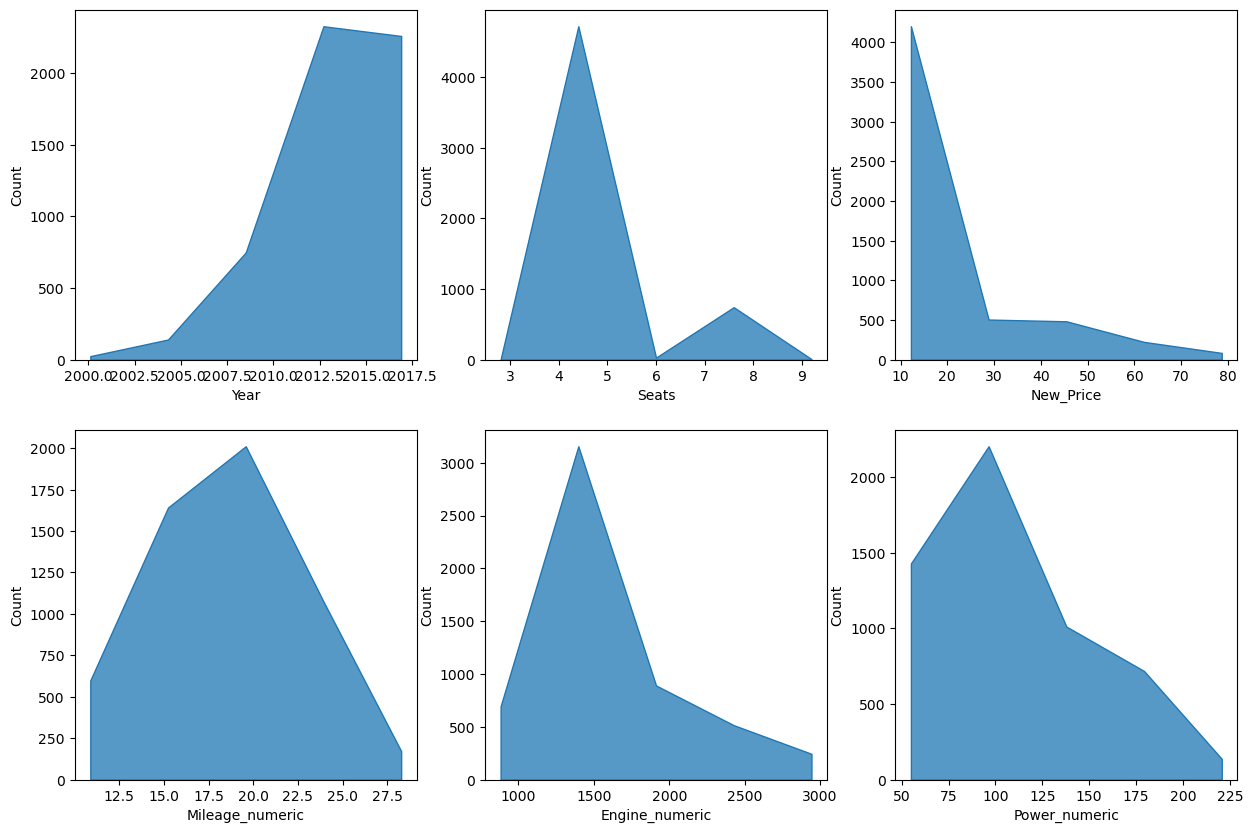

In [36]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
listOfColumns = ['Year', 'Seats', 'New_Price', 'Mileage_numeric', 'Engine_numeric','Power_numeric', 'kilometers_driven_log']
len_listOfColumns = len(listOfColumns)
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if(index < len_listOfColumns):
            ax[j][i] = sns.histplot(data=df, x = df[listOfColumns[index]],element="poly",ax = ax[j][i], bins=5)         
            index = index + 1 
fig.show()

In [37]:
numeric_columns = df.select_dtypes(include='number').columns
numeric_columns

Index(['Year', 'Seats', 'New_Price', 'Mileage_numeric', 'Engine_numeric',
       'Power_numeric', 'price_log', 'kilometers_driven_log'],
      dtype='object')

    3. Model Building: [15 Marks]
            A. Drop the missing values in price and ‘price_log’. [1 Mark]
            B. Create dummy variables for string type variables and convert other column types to float if any 
            [1 Mark]
            
            C. Model with Price
            i) Split the data into X and Y, where Y= Price and Drop ‘price_log’. [1 Mark]
            ii) Split the dataset into train and test sets with 70:30 proportion. [1 Mark]
            iii) Fit a linear regression model. [1 Mark]
            iv) Check the performance of the model using appropriate performance metrics. [2 Mark]
            
            D. Model with log_Price
            i) Split the data into X and Y, where Y= price_log and Drop ‘Price’. [1 Mark]
            ii) Split the dataset into train and test sets with 70:30 proportion. [1 Mark]
            iii) Fit a linear regression model. [1 Mark]
            iv) Check the performance of the model using appropriate performance metrics. [2 Mark]

In [38]:
# i) Split the data into X and Y, where Y = Price and Drop 'price_log'
Y = df['price_log']
X = df.drop(['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type',
       'Mileage_unit', 'Brand', 'Model'], axis=1)

# ii) Split the dataset into train and test sets with a 70:30 proportion
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# iii) Fit a linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# iv) Check the performance of the model using appropriate performance metrics
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Performance metrics
rmse_train = sqrt(mean_squared_error(Y_train, Y_pred_train))
rmse_test = sqrt(mean_squared_error(Y_test, Y_pred_test))
r2_train = r2_score(Y_train, Y_pred_train)
r2_test = r2_score(Y_test, Y_pred_test)

print("Performance Metrics:")
print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")
print(f"R-squared (Train): {r2_train}")
print(f"R-squared (Test): {r2_test}")

Performance Metrics:
Root Mean Squared Error (Train): 4.997065108360816e-14
Root Mean Squared Error (Test): 5.173043899967258e-14
R-squared (Train): 1.0
R-squared (Test): 1.0


In [39]:
# i) Split the data into X and Y, where Y = Price and Drop 'price_log'
Y = df['price_log']
X = df.drop(['price_log','Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type',
       'Mileage_unit', 'Brand', 'Model'], axis=1)

# ii) Split the dataset into train and test sets with a 70:30 proportion
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# iii) Fit a linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# iv) Check the performance of the model using appropriate performance metrics
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Performance metrics
rmse_train = sqrt(mean_squared_error(Y_train, Y_pred_train))
rmse_test = sqrt(mean_squared_error(Y_test, Y_pred_test))
r2_train = r2_score(Y_train, Y_pred_train)
r2_test = r2_score(Y_test, Y_pred_test)

print("Performance Metrics:")
print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")
print(f"R-squared (Train): {r2_train}")
print(f"R-squared (Test): {r2_test}")

Performance Metrics:
Root Mean Squared Error (Train): 0.2235581962641468
Root Mean Squared Error (Test): 0.22940596139067948
R-squared (Train): 0.8853623192069109
R-squared (Test): 0.8839181865287308


    E. Compare the performance of both for the train & test set and provide your insights.
        The Results with Price log looks promissiing. The Results with Price-log looks promising as it is not over-fitting rather than non log Price.  

4.Business Recommendation:
    
    A. Provide a detailed and useful Business Insights and Recommendation based on your observations and analysis

    The automobile dealer should focus on the car that have Good Engine with respectable condition which could give enough mileage that could attract customer, hence this will increase the profits on such cars The cars with lesser mileage, lesser seat and more driven cars may pose a lesser customer attraction which will decrease the profit. Selection of car as per the car demand will result in good profit.